In [1]:
from os import environ

from pyspark.sql import SparkSession

environ[
    'PYSPARK_PYTHON'] = "/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/venv/bin/python"
session = SparkSession.builder \
    .master("yarn") \
    .appName("web-archive-query-log-time-series") \
    .config("spark.executor.instances", 3) \
    .getOrCreate()

In [2]:
sc = session.sparkContext
sc

<SparkContext master=yarn appName=web-archive-query-log-query-length>

In [70]:
from pathlib import Path

# TODO: For final evaluation, use the full corpus.
corpus_dir = Path("/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/focused/corpus")
queries_dir = corpus_dir / "queries-2023-02-14"
# corpus_dir = Path("/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/focused/sample-corpus")
# queries_dir = corpus_dir / "queries"

In [71]:
from pathlib import Path

figures_dir = Path("figures")
figures_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
def group(query: dict) -> tuple:
    timestamp = datetime.fromtimestamp(query["timestamp"])
    return query["service"],   query["language"],   timestamp.year,   timestamp.month

In [72]:
from json import loads
from pandas import DataFrame
from datetime import datetime

counts = sc.textFile(f"file://{queries_dir}") \
    .map(lambda line: loads(line)) \
    .filter(lambda query: query["url_query"] is not None) \
    .keyBy(lambda query: query["id"]) \
    .mapValues(group) \
    .countByValue()

In [73]:

from math import log10

df = DataFrame([
    {
        "service": service,
        "language": language,
        "year": year,
        "month": month,
        "count": count,
        "log_count": log10(count),
    }
    for (service, language, year, month), count in counts.items()
])
df

year
1999       25556
2000     1357906
2001      277314
2002      455106
2003      419509
2004      260278
2005     1341800
2006      977793
2007     1302466
2008     1916674
2009     2839414
2010     2734954
2011     3663493
2012     7093003
2013    12882141
2014    12317200
2015    16173190
2016    11501944
2017    20177522
2018    27462834
2019    78620056
2020    49808115
2021    39554381
2022    50178579
Name: count, dtype: int64

In [ ]:
top_services = df.groupby("service")["count"].sum().sort_values(ascending=False).head(5).index
top_services

In [ ]:
df_plot = df.copy()
df_plot.loc[
    ~df_plot["service"].isin(top_services),
    "service",
] = "other"
df_plot["year"] = df_plot["year"].astype(str)
df_plot["month"] = df_plot["month"].astype(str)

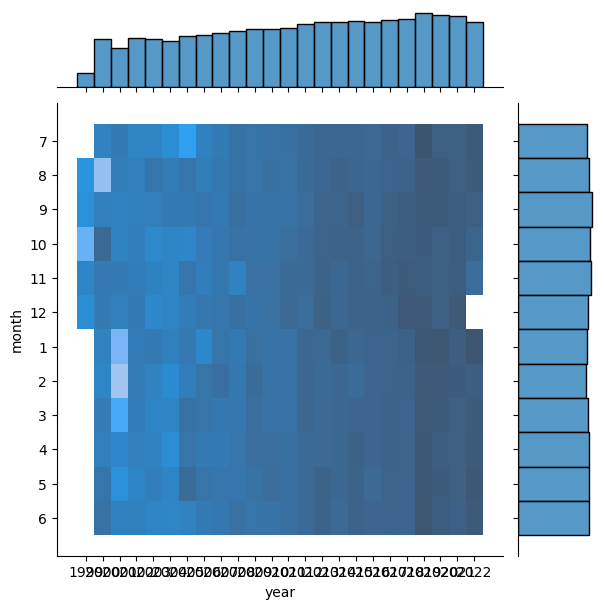

In [74]:
from seaborn import histplot, JointGrid

plot = JointGrid()
histplot(
    ax=plot.ax_joint,
    data=df,
    x="year",
    y="month",
    weights="log_count",
)
histplot(
    ax=plot.ax_marg_x,
    data=df,
    x="year",
    weights="log_count",
)

histplot(
    ax=plot.ax_marg_y,
    data=df,
    y="month",
    weights="log_count",
)
plot